In [2]:
#================================================================================================================
# Involutional Neural Networks (INNs)      # Eliya Christopher Nandi        # Involutional Neural Networks (INNs)      
#================================================================================================================

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import time
import psutil
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import warnings

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Suppress other warnings
warnings.filterwarnings('ignore')

# Set up GPU configuration
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth on all detected GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(f"RuntimeError during GPU configuration: {e}")


# Check the TensorFlow version
print("TensorFlow version:", tf.__version__)

1 Physical GPUs, 1 Logical GPUs
TensorFlow version: 2.16.1


In [3]:
# Define dataset path
dataset_path = "/kaggle/input/maize-disease/Model"

# Validate dataset path and count images
if not os.path.exists(dataset_path):
    print(f"Error: Dataset path {dataset_path} does not exist.")
else:
    image_counts = {class_name: len(os.listdir(os.path.join(dataset_path, class_name)))
                    for class_name in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, class_name))}
    print("Image counts per class:", image_counts)


Image counts per class: {'MLN': 3980, 'HEATHLY': 5117, 'MSV_2': 3095, 'MSV_1': 3157}


In [4]:
# Create ImageDataGenerator instances for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Define image size and batch size
img_height, img_width = 224, 224
batch_size = 32

# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    directory=dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Define involutional block
def involutional_block(x, filters, kernel_size=3):
    x_involution = layers.Conv2D(filters, kernel_size=kernel_size, padding='same', use_bias=False)(x)
    x_involution = layers.BatchNormalization()(x_involution)
    x_involution = layers.Activation('relu')(x_involution)
    return x_involution

# Create the model
def create_invnet_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = involutional_block(x, 64)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = involutional_block(x, 128)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = involutional_block(x, 256)
    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    return model

input_shape = (img_height, img_width, 3)
num_classes = len(train_generator.class_indices)
model = create_invnet_model(input_shape, num_classes)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Found 15349 images belonging to 4 classes.
Found 15349 images belonging to 4 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 523,396 (2.00 MB)

 Trainable params: 522,500 (1.99 MB)

 Non-trainable params: 896 (3.50 KB)

In [6]:
import os
import tensorflow as tf
import time
import psutil
from tensorflow import keras
from tensorflow.keras import layers

# Suppress TensorFlow warnings including XLA logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all messages, 3 = suppress all except critical errors

# Optionally disable XLA to avoid compilation delay
tf.config.optimizer.set_jit(False)  # Disable XLA

# Set up GPU configuration with updated approach
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except Exception as e:
        print(f"Error during GPU configuration: {e}")

# Calculate steps per epoch and validation steps
train_steps_per_epoch = train_generator.samples // batch_size
val_steps_per_epoch = val_generator.samples // batch_size

# Measure training time
start_time = time.time()

# Train the model with reduced verbosity
history = model.fit(
    train_generator,
    epochs=30,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    verbose=1  # Set to 1 or 2 for less verbosity, 0 for no output except epochs summary
)

end_time = time.time()
training_time = end_time - start_time

# Memory consumption
memory_info = psutil.virtual_memory()
memory_consumption = memory_info.used / (1024 ** 3)  # Convert bytes to GB

print(f"Average Training Time per Epoch: {training_time / 30:.2f} seconds")
print(f"Total Training Time: {training_time:.2f} seconds")
print(f"Memory Consumption: {memory_consumption:.2f} GB")

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_generator, steps=val_steps_per_epoch)
print(f"Loss on validation set: {val_loss:.4f}")
print(f"Accuracy on validation set: {val_accuracy:.4f}")


1 Physical GPUs, 1 Logical GPUs
Epoch 1/30
479/479 ━━━━━━━━━━━━━━━━━━━━ 380s 785ms/step - accuracy: 0.7957 - loss: 0.4905 - val_accuracy: 0.6801 - val_loss: 0.8796
Epoch 2/30
479/479 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8750 - loss: 0.3899 - val_accuracy: 0.0000e+00 - val_loss: 5.9682
Epoch 3/30
479/479 ━━━━━━━━━━━━━━━━━━━━ 315s 651ms/step - accuracy: 0.8352 - loss: 0.4027 - val_accuracy: 0.7384 - val_loss: 0.6166
Epoch 4/30
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9062 - loss: 0.3200 - val_accuracy: 0.0000e+00 - val_loss: 3.0451
Epoch 5/30
479/479 ━━━━━━━━━━━━━━━━━━━━ 312s 645ms/step - accuracy: 0.8537 - loss: 0.3613 - val_accuracy: 0.6120 - val_loss: 1.8138
Epoch 6/30
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8750 - loss: 0.2462 - val_accuracy: 0.5238 - val_loss: 1.1618
Epoch 7/30
479/479 ━━━━━━━━━━━━━━━━━━━━ 312s 644ms/step - accuracy: 0.8635 - loss: 0.3394 - val_accuracy: 0.7377 - val_loss: 0.5995
Epoch 8/30
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/s

Found 15349 images belonging to 4 classes.
480/480 ━━━━━━━━━━━━━━━━━━━━ 88s 184ms/step
Classification Report:
              precision    recall  f1-score   support

     HEATHLY       0.99      1.00      0.99      5117
         MLN       0.99      0.97      0.98      3980
       MSV_1       0.85      0.78      0.81      3157
       MSV_2       0.80      0.87      0.83      3095

    accuracy                           0.92     15349
   macro avg       0.91      0.90      0.90     15349
weighted avg       0.92      0.92      0.92     15349



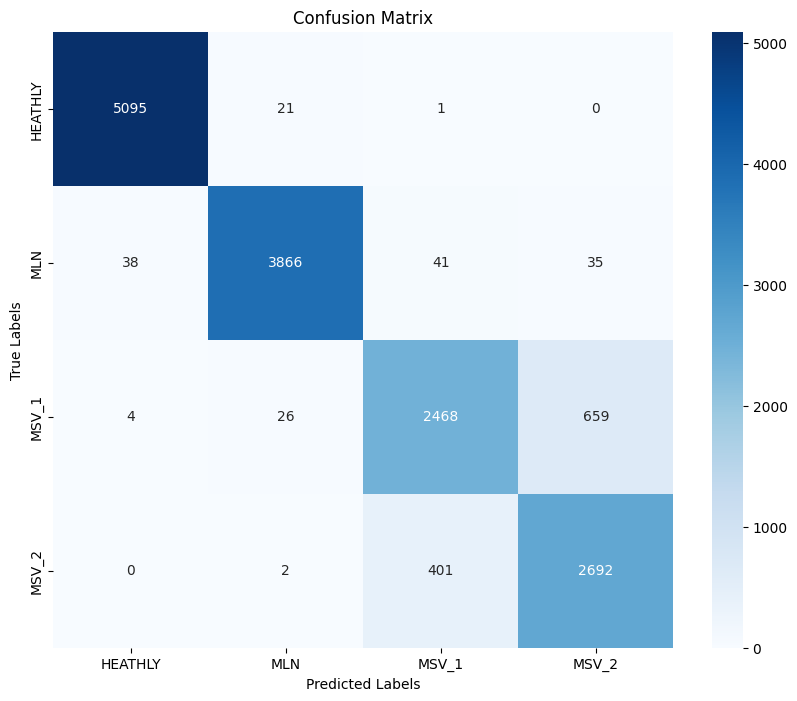

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Make sure the validation generator is properly set without shuffling
val_generator = val_datagen.flow_from_directory(
    directory=dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important to ensure the order of predictions matches true labels
)

# Get true labels from the validation generator
true_labels = val_generator.classes

# Get the class labels (class names)
class_labels = list(val_generator.class_indices.keys())

# Predict using the model on the entire validation set
predictions = model.predict(val_generator, steps=val_generator.samples // batch_size + 1, verbose=1)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Ensure lengths of true labels and predicted classes match
if len(predicted_classes) != len(true_labels):
    predicted_classes = predicted_classes[:len(true_labels)]  # Align lengths if there's an extra batch issue

# Generate the classification report
report = classification_report(true_labels, predicted_classes, target_names=class_labels)

# Print the classification report
print("Classification Report:")
print(report)

# Optional: Confusion Matrix Visualization
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [10]:
for layer in model.layers:
    print(layer.name)

input_layer
conv2d
max_pooling2d
conv2d_1
batch_normalization
activation
max_pooling2d_1
conv2d_2
batch_normalization_1
activation_1
max_pooling2d_2
conv2d_3
batch_normalization_2
activation_2
global_average_pooling2d
dense
dropout
dense_1


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


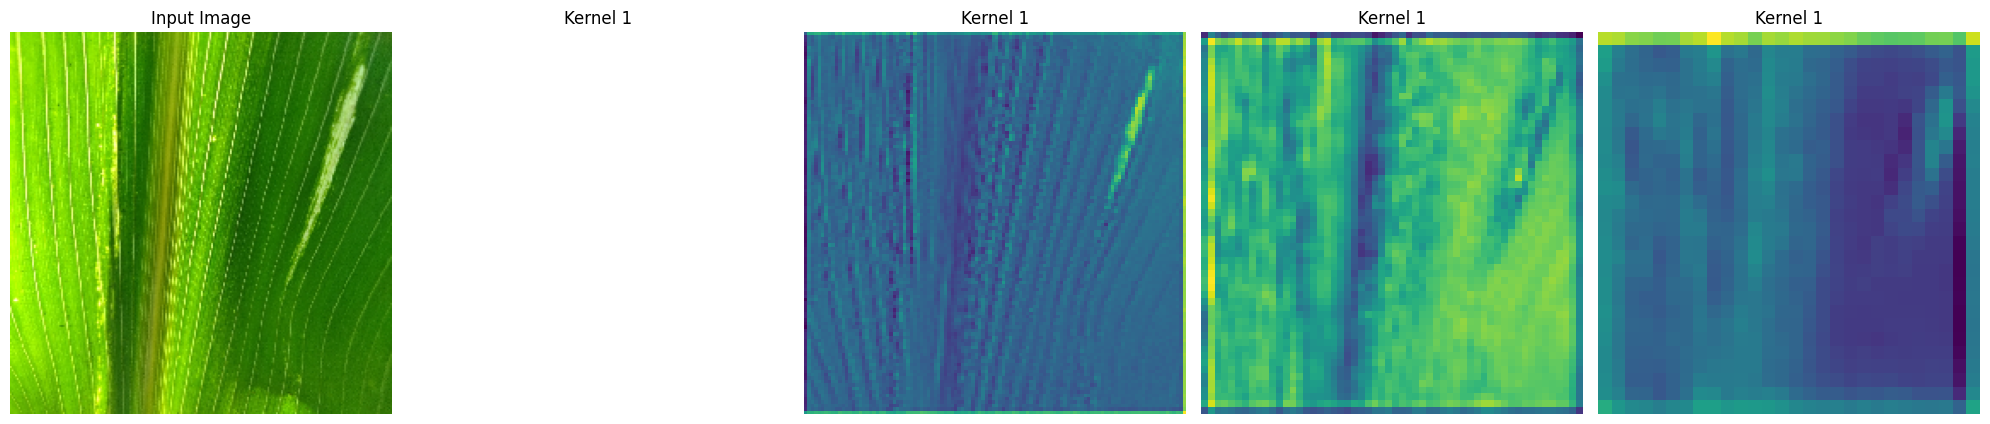

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


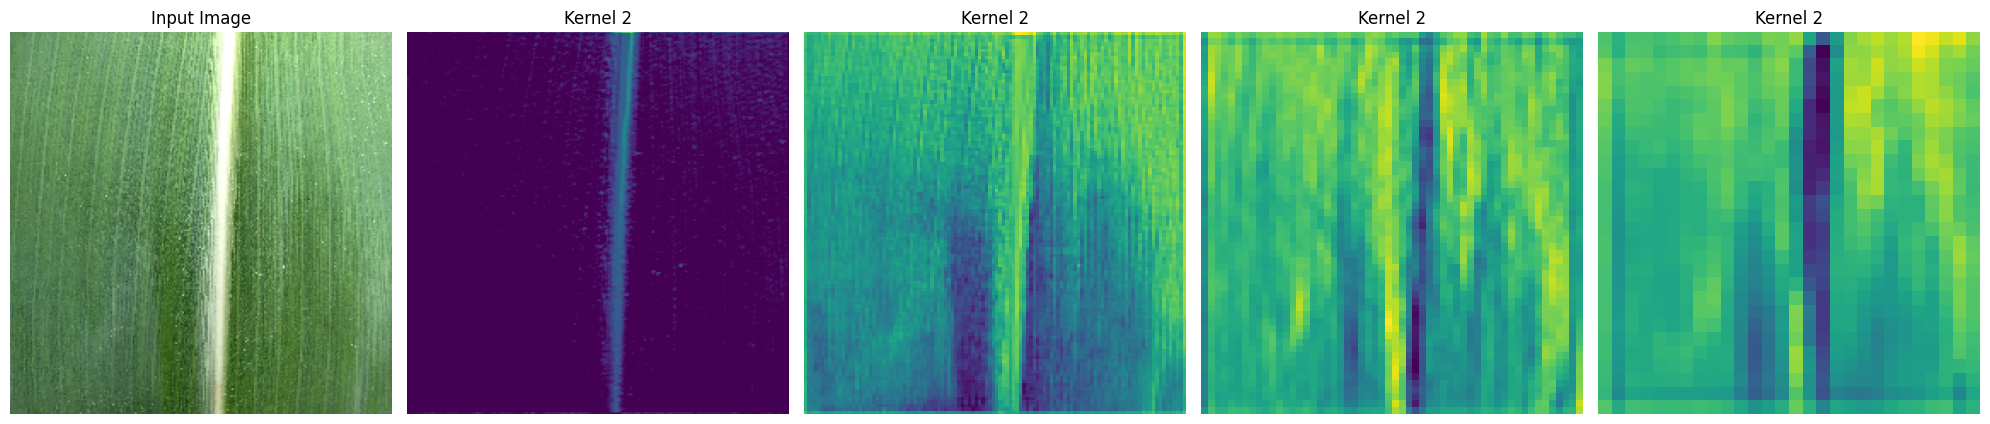

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


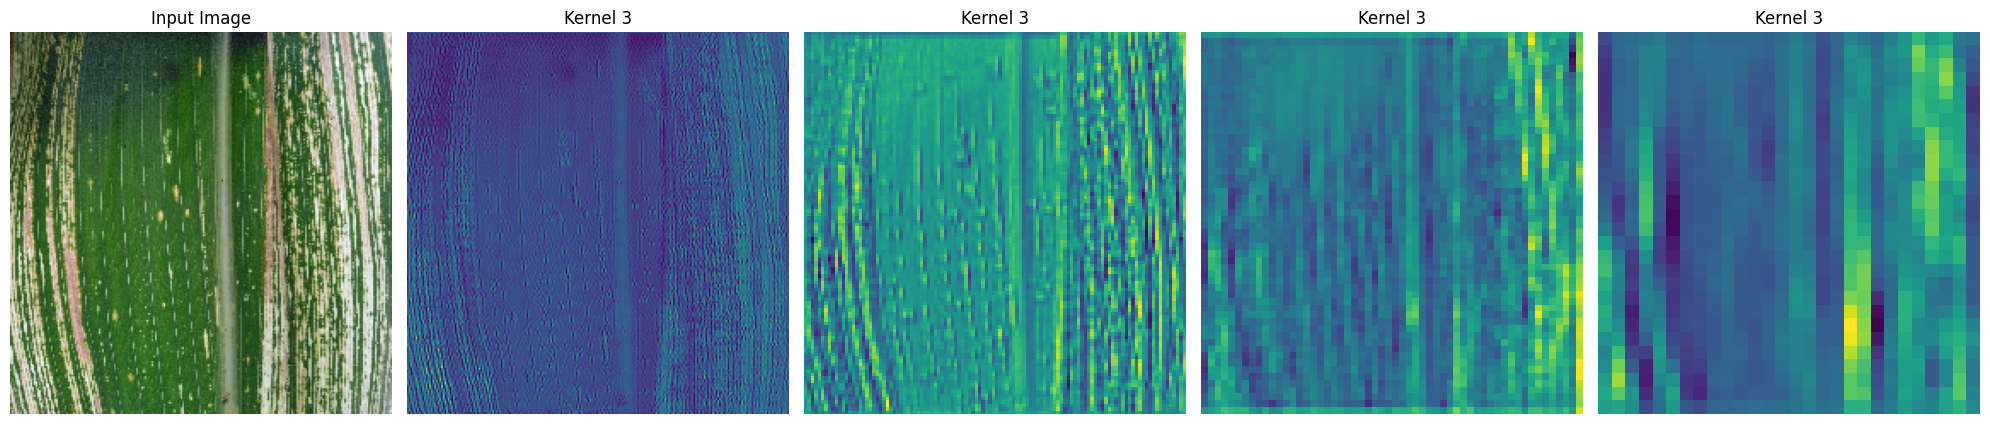

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import tensorflow.keras.utils as keras_utils
import os
import random

# Function to preprocess images for model input
def preprocess_image(img_path, target_size=(224, 224)):  # Adjusted to match model input size
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return img_array

# Function to visualize the input image and convolutional kernels
def visualize_input_and_kernels(model, img_path, layer_names, num_kernels=6):
    # Load and preprocess the image
    img_array = preprocess_image(img_path)

    # Create a model to get outputs from specified layers
    outputs = [model.get_layer(name).output for name in layer_names]
    vis_model = Model(inputs=model.input, outputs=outputs)
    
    # Get activations for the image
    activations = vis_model.predict(img_array)

    # Create a figure to display results
    fig, axes = plt.subplots(nrows=1, ncols=len(layer_names) + 1, figsize=(20, 5))

    # Display the input image
    axes[0].imshow(keras_utils.array_to_img(img_array[0]))
    axes[0].set_title("Input Image")
    axes[0].axis('off')

    for i in range(len(layer_names)):
        # Process kernel activations
        kernel_activation = activations[i]
        n_kernels = min(num_kernels, kernel_activation.shape[-1])
        
        for j in range(n_kernels):
            kernel = kernel_activation[0, :, :, j]
            # Normalize for better visualization
            kernel = (kernel - np.min(kernel)) / (np.max(kernel) - np.min(kernel))
            
            # Display the kernel
            ax = axes[i + 1]
            ax.imshow(kernel, cmap='viridis')
            ax.set_title(f"Kernel {j + 1}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Function to select a random image from the dataset
def get_random_image_path(dataset_path):
    # List all folders and images
    all_images = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_images.append(os.path.join(root, file))
    # Choose a random image
    return random.choice(all_images)

# Path to the dataset
dataset_path = '/kaggle/input/maize-disease/Model'

# Get a random image path
random_img_path1 = get_random_image_path(dataset_path)
random_img_path2 = get_random_image_path(dataset_path)
random_img_path3 = get_random_image_path(dataset_path)

# Updated layer names to match the available convolutional layers in your model
layer_names = [
    'conv2d',    # First convolutional layer
    'conv2d_1',  # Second convolutional layer
    'conv2d_2',  # Third convolutional layer
    'conv2d_3'   # Fourth convolutional layer
]

# Visualize the input image and convolutional kernels
visualize_input_and_kernels(model, random_img_path1, layer_names, num_kernels=1)
visualize_input_and_kernels(model, random_img_path2, layer_names, num_kernels=2)
visualize_input_and_kernels(model, random_img_path3, layer_names, num_kernels=3)


       Involutional Neural Networks=============**ELIYA CHRISTOPHER NANDI**=================Involutional Neural Networks